In [7]:
#!pip install --upgrade pip
#!pip show tensorflow-gpu

In [1]:
import tensorflow as tf
print(tf.__version__)
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    for gpu in gpus:
        print("GPU disponível:", gpu)
else:
    print("Nenhuma GPU disponível.")

2024-06-15 18:30:10.274250: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.15.0
Nenhuma GPU disponível.


In [423]:
"""import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Verifica as GPUs disponíveis
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    for gpu in gpus:
        print("GPU disponível:", gpu)
else:
    print("Nenhuma GPU disponível.")

print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

import keras
print(keras.__version__)

if tf.test.gpu_device_name():
    print('GPU found:', tf.test.gpu_device_name())
else:
    print("No GPU found")"""

'import tensorflow as tf\nprint("Num GPUs Available: ", len(tf.config.list_physical_devices(\'GPU\')))\n\n# Verifica as GPUs disponíveis\ngpus = tf.config.experimental.list_physical_devices(\'GPU\')\n\nif gpus:\n    for gpu in gpus:\n        print("GPU disponível:", gpu)\nelse:\n    print("Nenhuma GPU disponível.")\n\nprint("Num GPUs Available:", len(tf.config.experimental.list_physical_devices(\'GPU\')))\n\nimport keras\nprint(keras.__version__)\n\nif tf.test.gpu_device_name():\n    print(\'GPU found:\', tf.test.gpu_device_name())\nelse:\n    print("No GPU found")'

In [424]:
import tensorflow as tf
from model_RA.dataset_RA import Dataset
#from model.fp.melspec.melspectrogram import get_melspec_layer
from model_RA.fp_RA.specaug_chain.specaug_chain_RA import get_specaug_chain_layer
from model_RA.fp_RA.nnfp import get_fingerprinter
from model_RA.fp_RA.NTxent_loss_single_gpu import NTxentLoss
from model_RA.fp_RA.online_triplet_loss import OnlineTripletLoss
from model_RA.fp_RA.lamb_optimizer import LAMB
from model.utils.experiment_helper import ExperimentHelper
import glob
from model_RA.utils.dataloader_keras import genUnbalSequence
import matplotlib.pyplot as plt
%matplotlib inline

In [425]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Lambda, Permute
from kapre.time_frequency import Magnitude #STFT, #, ApplyFilterbank
import math

In [426]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

from kapre import backend
from kapre.backend import _CH_FIRST_STR, _CH_LAST_STR, _CH_DEFAULT_STR

In [427]:
from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import tensor_util
import numpy as np
from tensorflow.python.framework import constant_op
from tensorflow.python.framework import dtypes
from tensorflow.python.ops.signal import window_ops
from tensorflow.python.ops.signal import shape_ops
from tensorflow.python.ops.signal import fft_ops
from tensorflow.python.util import dispatch

In [428]:
#def _enclosing_power_of_two(value):
  #"""Return 2**N for integer N such that 2**N >= value."""
"""
  value_static = tensor_util.constant_value(value)
  if value_static is not None:
    return constant_op.constant(
        int(2**np.ceil(np.log(value_static) / np.log(2.0))), value.dtype)
  return math_ops.cast(
      math_ops.pow(
          2.0,
          math_ops.ceil(
              math_ops.log(math_ops.cast(value, dtypes.float32)) /
              math_ops.log(2.0))), value.dtype)"""

'\n  value_static = tensor_util.constant_value(value)\n  if value_static is not None:\n    return constant_op.constant(\n        int(2**np.ceil(np.log(value_static) / np.log(2.0))), value.dtype)\n  return math_ops.cast(\n      math_ops.pow(\n          2.0,\n          math_ops.ceil(\n              math_ops.log(math_ops.cast(value, dtypes.float32)) /\n              math_ops.log(2.0))), value.dtype)'

In [429]:
"""@dispatch.add_dispatch_support
def stft(signals, frame_length, frame_step, fft_length=None,
         window_fn=window_ops.hann_window,
         pad_end=False, name=None):
  with ops.name_scope(name, 'stft', [signals, frame_length,
                                     frame_step]):
    #tf.print(f"window_fn:{window_fn}")
    signals = ops.convert_to_tensor(signals, name='signals')
    signals.shape.with_rank_at_least(1)
    frame_length = ops.convert_to_tensor(frame_length, name='frame_length')
    frame_length.shape.assert_has_rank(0)
    frame_step = ops.convert_to_tensor(frame_step, name='frame_step')
    frame_step.shape.assert_has_rank(0)

    #tf.print(f"frame_length:{frame_length}")

    if fft_length is None:
      fft_length = _enclosing_power_of_two(frame_length)
    else:
      fft_length = ops.convert_to_tensor(fft_length, name='fft_length')

    #tf.print(f"fft_length:{fft_length}")

    framed_signals = shape_ops.frame(
        signals, frame_length, frame_step, pad_end=pad_end)
    
    tf.print(f"framed_signals{framed_signals}")#ver uns tf.prints aqui

    # Optionally window the framed signals.
    if window_fn is not None:
      window = window_fn(frame_length, dtype=framed_signals.dtype)
      framed_signals *= window
      #tf.print(f"window{window}")
      #tf.print(f"framed_signals{framed_signals}")

    #tf.print(f"rfft{fft_ops.rfft(framed_signals, [fft_length])}")
    # fft_ops.rfft produces the (fft_length/2 + 1) unique components of the
    # FFT of the real windowed signals in framed_signals.
    return fft_ops.rfft(framed_signals, [fft_length])"""

'@dispatch.add_dispatch_support\ndef stft(signals, frame_length, frame_step, fft_length=None,\n         window_fn=window_ops.hann_window,\n         pad_end=False, name=None):\n  with ops.name_scope(name, \'stft\', [signals, frame_length,\n                                     frame_step]):\n    #tf.print(f"window_fn:{window_fn}")\n    signals = ops.convert_to_tensor(signals, name=\'signals\')\n    signals.shape.with_rank_at_least(1)\n    frame_length = ops.convert_to_tensor(frame_length, name=\'frame_length\')\n    frame_length.shape.assert_has_rank(0)\n    frame_step = ops.convert_to_tensor(frame_step, name=\'frame_step\')\n    frame_step.shape.assert_has_rank(0)\n\n    #tf.print(f"frame_length:{frame_length}")\n\n    if fft_length is None:\n      fft_length = _enclosing_power_of_two(frame_length)\n    else:\n      fft_length = ops.convert_to_tensor(fft_length, name=\'fft_length\')\n\n    #tf.print(f"fft_length:{fft_length}")\n\n    framed_signals = shape_ops.frame(\n        signals, f

In [430]:
class STFT(Layer):
    def __init__(
        self,
        n_fft=2048,
        win_length=None,
        hop_length=None,
        window_name=None,
        pad_begin=False,
        pad_end=False,
        input_data_format='default',
        output_data_format='default',
        **kwargs,
    ):
        super(STFT, self).__init__(**kwargs)

        backend.validate_data_format_str(input_data_format)
        backend.validate_data_format_str(output_data_format)

        if win_length is None:
            win_length = n_fft
        if hop_length is None:
            hop_length = win_length // 4

        self.n_fft = n_fft
        self.win_length = win_length
        self.hop_length = hop_length
        self.window_name = window_name
        self.window_fn = backend.get_window_fn(window_name)
        self.pad_begin = pad_begin
        self.pad_end = pad_end

        idt, odt = input_data_format, output_data_format
        self.output_data_format = K.image_data_format() if odt == _CH_DEFAULT_STR else odt
        self.input_data_format = K.image_data_format() if idt == _CH_DEFAULT_STR else idt

    def call(self, x):
        #tf.print(f"x antes waveform:{x.shape, type(x), x}")
        waveforms = x  # (batch, ch, time) if input_data_format == 'channels_first'.
        # (batch, time, ch) if input_data_format == 'channels_last'.

        # this is needed because tf.signal.stft lives in channels_first land.
        if self.input_data_format == _CH_LAST_STR:
            waveforms = tf.transpose(
                waveforms, perm=(0, 2, 1)
            )  # always (batch, ch, time) from here

        if self.pad_begin:
            waveforms = tf.pad(
                waveforms, tf.constant([[0, 0], [0, 0], [int(self.n_fft - self.hop_length), 0]])
            )
        #tf.print(f"self.pad_begin={self.pad_begin}, self.input_data_format={self.input_data_format}")
        #tf.print(f"waveforms{waveforms.shape, type(waveforms), waveforms}")
        
        #tf.print(f"waveforms:{waveforms}")
        #tf.print(f"self.win_length:{self.win_length}")
        #tf.print(f"self.hop_length:{self.hop_length}")
        #tf.print(f"self.n_fft:{self.n_fft}")
        #tf.print(f"self.pad_end:{self.pad_end}")
        #tf.print(f"self.name:{self.name}")
            
        stfts = tf.signal.stft(
            signals=waveforms,
            frame_length=self.win_length,
            frame_step=self.hop_length,
            fft_length=self.n_fft,
            window_fn=self.window_fn,
            pad_end=self.pad_end,
            name='%s_tf.signal.stft' % self.name,
        )  # (batch, ch, time, freq)
        
        #tf.print(f"stfts:{stfts}")

        if self.output_data_format == _CH_LAST_STR:
            stfts = tf.transpose(stfts, perm=(0, 2, 3, 1))  # (batch, t, f, ch)

        #tf.print(f"self.output_data_format={self.output_data_format}")
        #tf.print(f"stfts{stfts.shape, type(stfts), stfts}")
        return stfts

    def get_config(self):
        config = super(STFT, self).get_config()
        config.update(
            {
                'n_fft': self.n_fft,
                'win_length': self.win_length,
                'hop_length': self.hop_length,
                'window_name': self.window_name,
                'pad_begin': self.pad_begin,
                'pad_end': self.pad_end,
                'input_data_format': self.input_data_format,
                'output_data_format': self.output_data_format,
            }
        )
        return config

In [431]:
import math
import librosa
#%matplotlib widget
import matplotlib.pyplot as plt

In [432]:
from kapre.time_frequency import ApplyFilterbank

class CustomApplyFilterbank(ApplyFilterbank):
    def __init__(self, type, filterbank_kwargs, data_format='default', **kwargs):
        super(CustomApplyFilterbank, self).__init__(type, filterbank_kwargs, data_format, **kwargs)

        # tipo de Banco de filtros
        if type == 'tri':
            self.filterbank = self.filterbank_triangular_log(**filterbank_kwargs)

        if data_format == _CH_DEFAULT_STR:
            self.data_format = K.image_data_format()
        else:
            self.data_format = data_format

        if self.data_format == _CH_FIRST_STR:
            self.freq_axis = 3
        else:
            self.freq_axis = 2

    def filterbank_triangular_log(self, sample_rate, n_fft):
        # Com o objetivo de ter 256 filtros e 8000 Hz na frequência de amostragem, teve-se de optar por Nfft de 2048, o que resulta em 54.4024 filtros por oitava, e numa frequência mínima de 151.3483 Hz.

        # Sendo assim, o Nfpo será 60, 5*12, e a frequência do último filtro, f256, será Si7 = 3951.066410048992 Hz. Resultando numa frequência máxima de 3996.975590329487 Hz.
        # Com isto, obtem-se pelo menos um bin em cada filtro, visto que f0*(2^(2/Nfpo)-1) = 4.7979 > 8000/2048 = 3.9062. Para uma Nfft de 1024, não era certo que obtivesse pelo menos um bin por filtro.
        #O primeiro filtro estava a zero.

        n_fft=2048
        sample_rate=8000
        Nfpo=60 #=5*12
        Nb =256

        #Cálculo da fmin e fmax
        f256 = 440*2.**(38/12) # Si7 = 3951.066410048992 Hz;
        f0=f256/2**(256/Nfpo) # fmin, 205.2672581380976 Hz
        fmax = f0*2**(257/Nfpo) # fmax, 3996.975590329487 Hz

        #Depois disto, dá bins em todos os fitros. Ver a linha 24 do getOctaveFilterBanck2.m

        i=np.arange(0,Nb+2, dtype=np.int32)
        k=np.arange(0, n_fft//2+1, dtype=int)
        f=k*sample_rate/n_fft
        #f = np.log2(1 + np.arange(0, n_fft // 2 + 1)) * sample_rate / n_fft


        fcf = f0 * 2.**(i/Nfpo) #3905.68454168 - fcf está a incluir f0, fcf e fmax

        #fi = np.concatenate(([f0], fcf, [fmax])) #fi =[f0, fcf, fmax] 
        #fcf está a incluir f0, fcf e fmax
        #tf.print(f"fcf:{fcf}")

        # Construct the output matrix
        H = np.zeros((Nb, n_fft // 2 + 1))

        #for i in range(n_filters), com isto são 256
        for j in range(Nb):
            fLow = fcf[j] 
            fmid = fcf[j+1] 
            fUpp = fcf[j+2]

            H[j, :] = ((f - fLow) / (fmid - fLow)) * ((f > fLow) & (f <= fmid)) + \
                            ((f - fUpp) / (fmid - fUpp)) * ((f > fmid) & (f <= fUpp))
            

        #H /= np.sum(H, axis=1, keepdims=True) # : A matriz é normalizada ao longo do eixo 1 (linhas), dividindo cada valor pela soma dos valores na respectiva linha. Isto garante que a soma de cada linha seja igual a 1.65
        
        #Ver os filtros
        """
        plt.figure(figsize=(10, 6))
        for j in range(Nb):
            plt.plot(f, H[j, :])
        plt.title('Triangular Log Filterbank')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Amplitude')
        plt.grid(True)
        plt.show()
        """
        #tf.print(i, k, f)
        #tf.print(f256, f0, fmax)
        #Ver uma oitava dos filtros
        """
        # Filtrar para uma oitava
        octave_filter_indices = np.where((fcf >= f0) & (fcf <= fmax))[0]
        #octave_filters = H[octave_filter_indices, :]
        #tf.print(octave_filter_indices[:60])
        octave_filter_indices= octave_filter_indices[:60]
        tf.print(octave_filter_indices)
        
        # Plot dos filtros
        plt.figure(figsize=(12, 8), dpi=300)
        for filter_idx in octave_filter_indices:
            plt.plot(f, H[filter_idx, :], label=f'Filter {filter_idx}')
        
        plt.title('Primeira Oitava do Banco de Filtros', fontsize=16)
        plt.xlabel('Frequência (Hz)', fontsize=14)
        plt.ylabel('Amplitude', fontsize=14)
        #plt.legend()
        #plt.grid(True)
        #plt.xscale('log', base=2)
        plt.xlim(200, 430)  # Ajuste o limite superior do eixo x conforme necessário
        plt.show()
        """

        #Ver alguns filtros da primeira oitava
        #"""        
        octave_filter_indices = np.where((fcf >= f0) & (fcf <= fmax))[0]
        octave_filter_indices= octave_filter_indices[:9]

        tf.print(octave_filter_indices)
        
        # Plot dos filtros
        plt.figure(figsize=(12, 8), dpi=300)
        for filter_idx in octave_filter_indices:
            plt.plot(f, H[filter_idx, :], label=f'Filter {filter_idx}')
        
        plt.title('Primeira Oitava do Banco de Filtros', fontsize=16)
        plt.xlabel('Frequência (Hz)', fontsize=14)
        plt.ylabel('Amplitude', fontsize=14)
        #plt.xscale('log', base=2))
        plt.xlim(200, 225)  # Ajuste o limite superior do eixo x conforme necessário
        plt.show()
        #"""

        """
        octave_filter_indices = np.where((fcf >= f0) & (fcf <= fmax))[0]
        octave_filter_indices=octave_filter_indices[:60]
        #tf.print(octave_filter_indices[:60])

        # Transformar frequências para log2
        f_log2 = np.log2(f + 1e-10)  # Adicionar pequeno valor para evitar log de zero

        # Plot dos filtros
        plt.figure(figsize=(12, 8), dpi=300)  # Aumentar dpi para melhor qualidade
        for filter_idx in octave_filter_indices:
            plt.plot(f_log2, H[filter_idx, :], label=f'Filter {filter_idx}')
        
        plt.title('One Octave of Triangular Filters', fontsize=16)
        plt.xlabel('Log2 Frequency (Hz)', fontsize=14)
        plt.ylabel('Amplitude', fontsize=14)
        plt.xlim(np.log2(f0), np.log2(fmax))  # Ajuste o limite superior do eixo x conforme necessário
        plt.grid(True, which="both", ls="--")
        plt.show()
        """

        return tf.convert_to_tensor(H.T, dtype=tf.float32)
        #return tf.convert_to_tensor(H.T)
    

    def call(self, x):
        #tf.print(f"self.filterbank_shape={self.filterbank.shape}")
        output = tf.tensordot(x, self.filterbank, axes=(self.freq_axis, 0))
        #tf.print(f"x={x}")
                
        if self.data_format == _CH_LAST_STR:
            output = tf.transpose(output, (0, 1, 3, 2))
        return output

In [433]:
class MagnitudeSquared(Layer):
    def call(self, x):
        return tf.abs(x)**2

In [434]:
class Melspec_layer(Model):
    """
    A wrapper class, based on the implementation:
        https://github.com/keunwoochoi/kapre
        
    Input:
        (B,1,T)
    Output:
        (B,C,T,1) with C=Number of mel-bins
    
    USAGE:
        
        See get_melspec_layer() in the below.
        
    """
    def __init__(
            self,
            input_shape=(1, 8000),
            segment_norm=False,
            n_fft=2048,
            stft_hop=258,
            n_win=1549, # = 6*M+1, Window Length
            n_mels=256,
            fs=8000,
            dur=1.,
            f_min=300,
            f_max=4000.,
            amin=10**(-20/10), # minimum amp.
            dynamic_range=80.,
            use_pad_layer=False,
            name='Mel-spectrogram',
            trainable=False,
            **kwargs
            ):
        super(Melspec_layer, self).__init__(name=name, trainable=False, **kwargs)
        
        self.mel_fb_kwargs = {
            'sample_rate': fs,
            'n_freq': n_fft // 2 + 1,
            'n_mels': n_mels,
            'f_min': f_min,
            'f_max': f_max,
            }
        
        self.tri_fb_kwargs = {
            'sample_rate': fs,
            'n_fft': n_fft,
            }
            
        self.n_fft = n_fft
        self.stft_hop = stft_hop
        self.n_mels = n_mels
        self.amin = amin
        self.dynamic_range = dynamic_range
        self.segment_norm = segment_norm

        self.n_win = n_win #RA

        #Padding para type ='mel'
         # 'SAME' Padding layer
        self.use_pad_layer = use_pad_layer
        self.pad_l = n_fft // 2
        self.pad_r = n_fft // 2
        self.padded_input_shape = (1, int(fs * dur) + self.pad_l + self.pad_r)
        self.pad_layer = Lambda(
            lambda z: tf.pad(z, tf.constant([[0, 0], [0, 0],
                                             [self.pad_l, self.pad_r]]))
            )

        #Padding para type ='tri'
        self.Npad_l = 3*self.stft_hop
        self.Npad_r = 3*self.stft_hop-1
        self.padded_input_shape_RA = (1, int(fs * dur) + self.Npad_l + self.Npad_r) #self.padded_input_shape:(1, 9547)
        self.pad_layer_RA = Lambda(
            lambda z: tf.pad(z, tf.constant([[0, 0], [0, 0],
                                             [self.Npad_l, self.Npad_r]]))
            )  #onde fs=31*M+2
        
        #tf.print(f"self.padded_input_shape:{self.padded_input_shape_RA}")
        #tf.print(f"self.pad_layer_RA:{self.pad_layer_RA}")


        # Construct log-power Mel-spec layer
        self.m = self.construct_melspec_layer(input_shape, name)


        # Permute layer
        self.p = tf.keras.Sequential(name='Permute')
        self.p.add(Permute((3, 2, 1), input_shape=self.m.output_shape[1:]))
        
        super(Melspec_layer, self).build((None, input_shape[0], input_shape[1]))
        
        
    def construct_melspec_layer(self, input_shape, name):
        m = tf.keras.Sequential(name=name)
        m.add(tf.keras.layers.InputLayer(input_shape=input_shape))
        """if self.use_pad_layer: #mel e log
            m.add(self.pad_layer)
        else: #tri
            m.add(self.pad_layer_RA)"""
        m.add(self.pad_layer_RA)
        #tf.print(f"m:{m}")
        m.add(
            STFT(
                n_fft=self.n_fft,
                win_length=self.n_win,
                hop_length=self.stft_hop,
                window_name='hamming_window',#'hamming_window',
                pad_begin=False, # We do not use Kapre's padding, due to the @tf.function compatiability
                pad_end=False, # We do not use Kapre's padding, due to the @tf.function compatiability
                input_data_format='channels_first',
                output_data_format='channels_first')
            )
        m.add(
            MagnitudeSquared()
            )
        m.add(
            CustomApplyFilterbank(type='tri', #pode ser 'tri', 'log', ou 'mel'
                            filterbank_kwargs=self.tri_fb_kwargs,
                            data_format='channels_first'
                            )
            )
        return m
        

    @tf.function
    def call(self, x):
        #tf.print(f"x={x, type(x), x.shape}")
        x = self.m(x) + 0.06
        #x = tf.sqrt(x)
        
        #tf.print(f"x={x, type(x), x.shape}")
        #tf.print(f"maximo={tf.maximum(x, self.amin)}")
        #tf.print(f"x_contas={tf.math.log(tf.maximum(x, self.amin)) / math.log(10)}")
        
        #x = tf.math.log(tf.maximum(x, self.amin)) / math.log(10) # ver se usa o 20 aqui, com 20 ficava em db, sem 20 não
        x = 10* (tf.math.log(tf.maximum(x, self.amin)) / math.log(10))
        tf.print(f"x do log={x[0] }")
        
        x = x - tf.reduce_max(x)
        x = tf.maximum(x, -1 * self.dynamic_range) #ver os dados do x aqui
        if self.segment_norm:
            x = (x - tf.reduce_min(x) / 2) / tf.abs(tf.reduce_min(x) / 2 + 1e-10)
        return self.p(x) # Permute((3,2,1))
    

def get_melspec_layer(cfg, trainable=False):
    #type - 'mel' filter bank
    """fs = cfg['MODEL']['FS']
    dur = cfg['MODEL']['DUR']
    n_fft = cfg['MODEL']['STFT_WIN']
    stft_hop = cfg['MODEL']['STFT_HOP']
    n_mels = cfg['MODEL']['N_MELS']
    f_min = cfg['MODEL']['F_MIN']
    f_max = cfg['MODEL']['F_MAX']
    if cfg['MODEL']['FEAT'] == 'melspec':
        segment_norm = False
    elif cfg['MODEL']['FEAT'] == 'melspec_maxnorm':
        segment_norm = True
    else:
        raise NotImplementedError(cfg['MODEL']['FEAT'])
    use_pad_layer = True"""

    #type - 'tri' filter bank
    fs = cfg['MODEL']['FS']
    dur = cfg['MODEL']['DUR']
    n_fft = cfg['MODEL']['STFT_WIN']
    stft_hop = cfg['MODEL']['STFT_HOP']
    n_win = cfg['MODEL']['N_WIN'] #RA
    n_mels = cfg['MODEL']['N_MELS']
    f_min = cfg['MODEL']['F_MIN']
    f_max = cfg['MODEL']['F_MAX']
    if cfg['MODEL']['FEAT'] == 'melspec':
        segment_norm = False
    elif cfg['MODEL']['FEAT'] == 'melspec_maxnorm':
        segment_norm = True
    else:
        raise NotImplementedError(cfg['MODEL']['FEAT'])
    use_pad_layer = False
    
    input_shape = (1, int(fs * dur))
    l = Melspec_layer(input_shape=input_shape,
                      segment_norm=segment_norm,
                      n_fft=n_fft,
                      stft_hop=stft_hop,
                      n_win=n_win, #RA
                      n_mels=n_mels,
                      fs=fs,
                      dur=dur,
                      f_min=f_min,
                      f_max=f_max,
                      use_pad_layer=use_pad_layer)#RA
    l.trainable = trainable
    return l

In [435]:
def build_fp(cfg):
    """ Build fingerprinter """
    # m_pre: log-power-Mel-spectrogram layer, S.
    m_pre = get_melspec_layer(cfg, trainable=False)

    # m_specaug: spec-augmentation layer.
    m_specaug = get_specaug_chain_layer(cfg, trainable=False)
    assert(m_specaug.bypass==False) # Detachable by setting m_specaug.bypass.

    # m_fp: fingerprinter g(f(.)).
    m_fp = get_fingerprinter(cfg, trainable=False)
    return m_pre, m_specaug, m_fp

In [436]:
import os
import sys
import pathlib
import click
import yaml
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

def load_config(config_fname):
    config_filepath = './config/' + config_fname + '.yaml'
    if os.path.exists(config_filepath):
        print(f'cli: Configuration from {config_filepath}')
    else:
        sys.exit(f'cli: ERROR! Configuration file {config_filepath} is missing!!')

    with open(config_filepath, 'r') as f:
        cfg = yaml.safe_load(f)
    return cfg

In [437]:
config = "default_RA"
cfg = load_config(config)
checkpoint_name = "Checks"

cli: Configuration from ./config/default_RA.yaml


array([0, 1, 2, 3, 4, 5, 6, 7, 8])


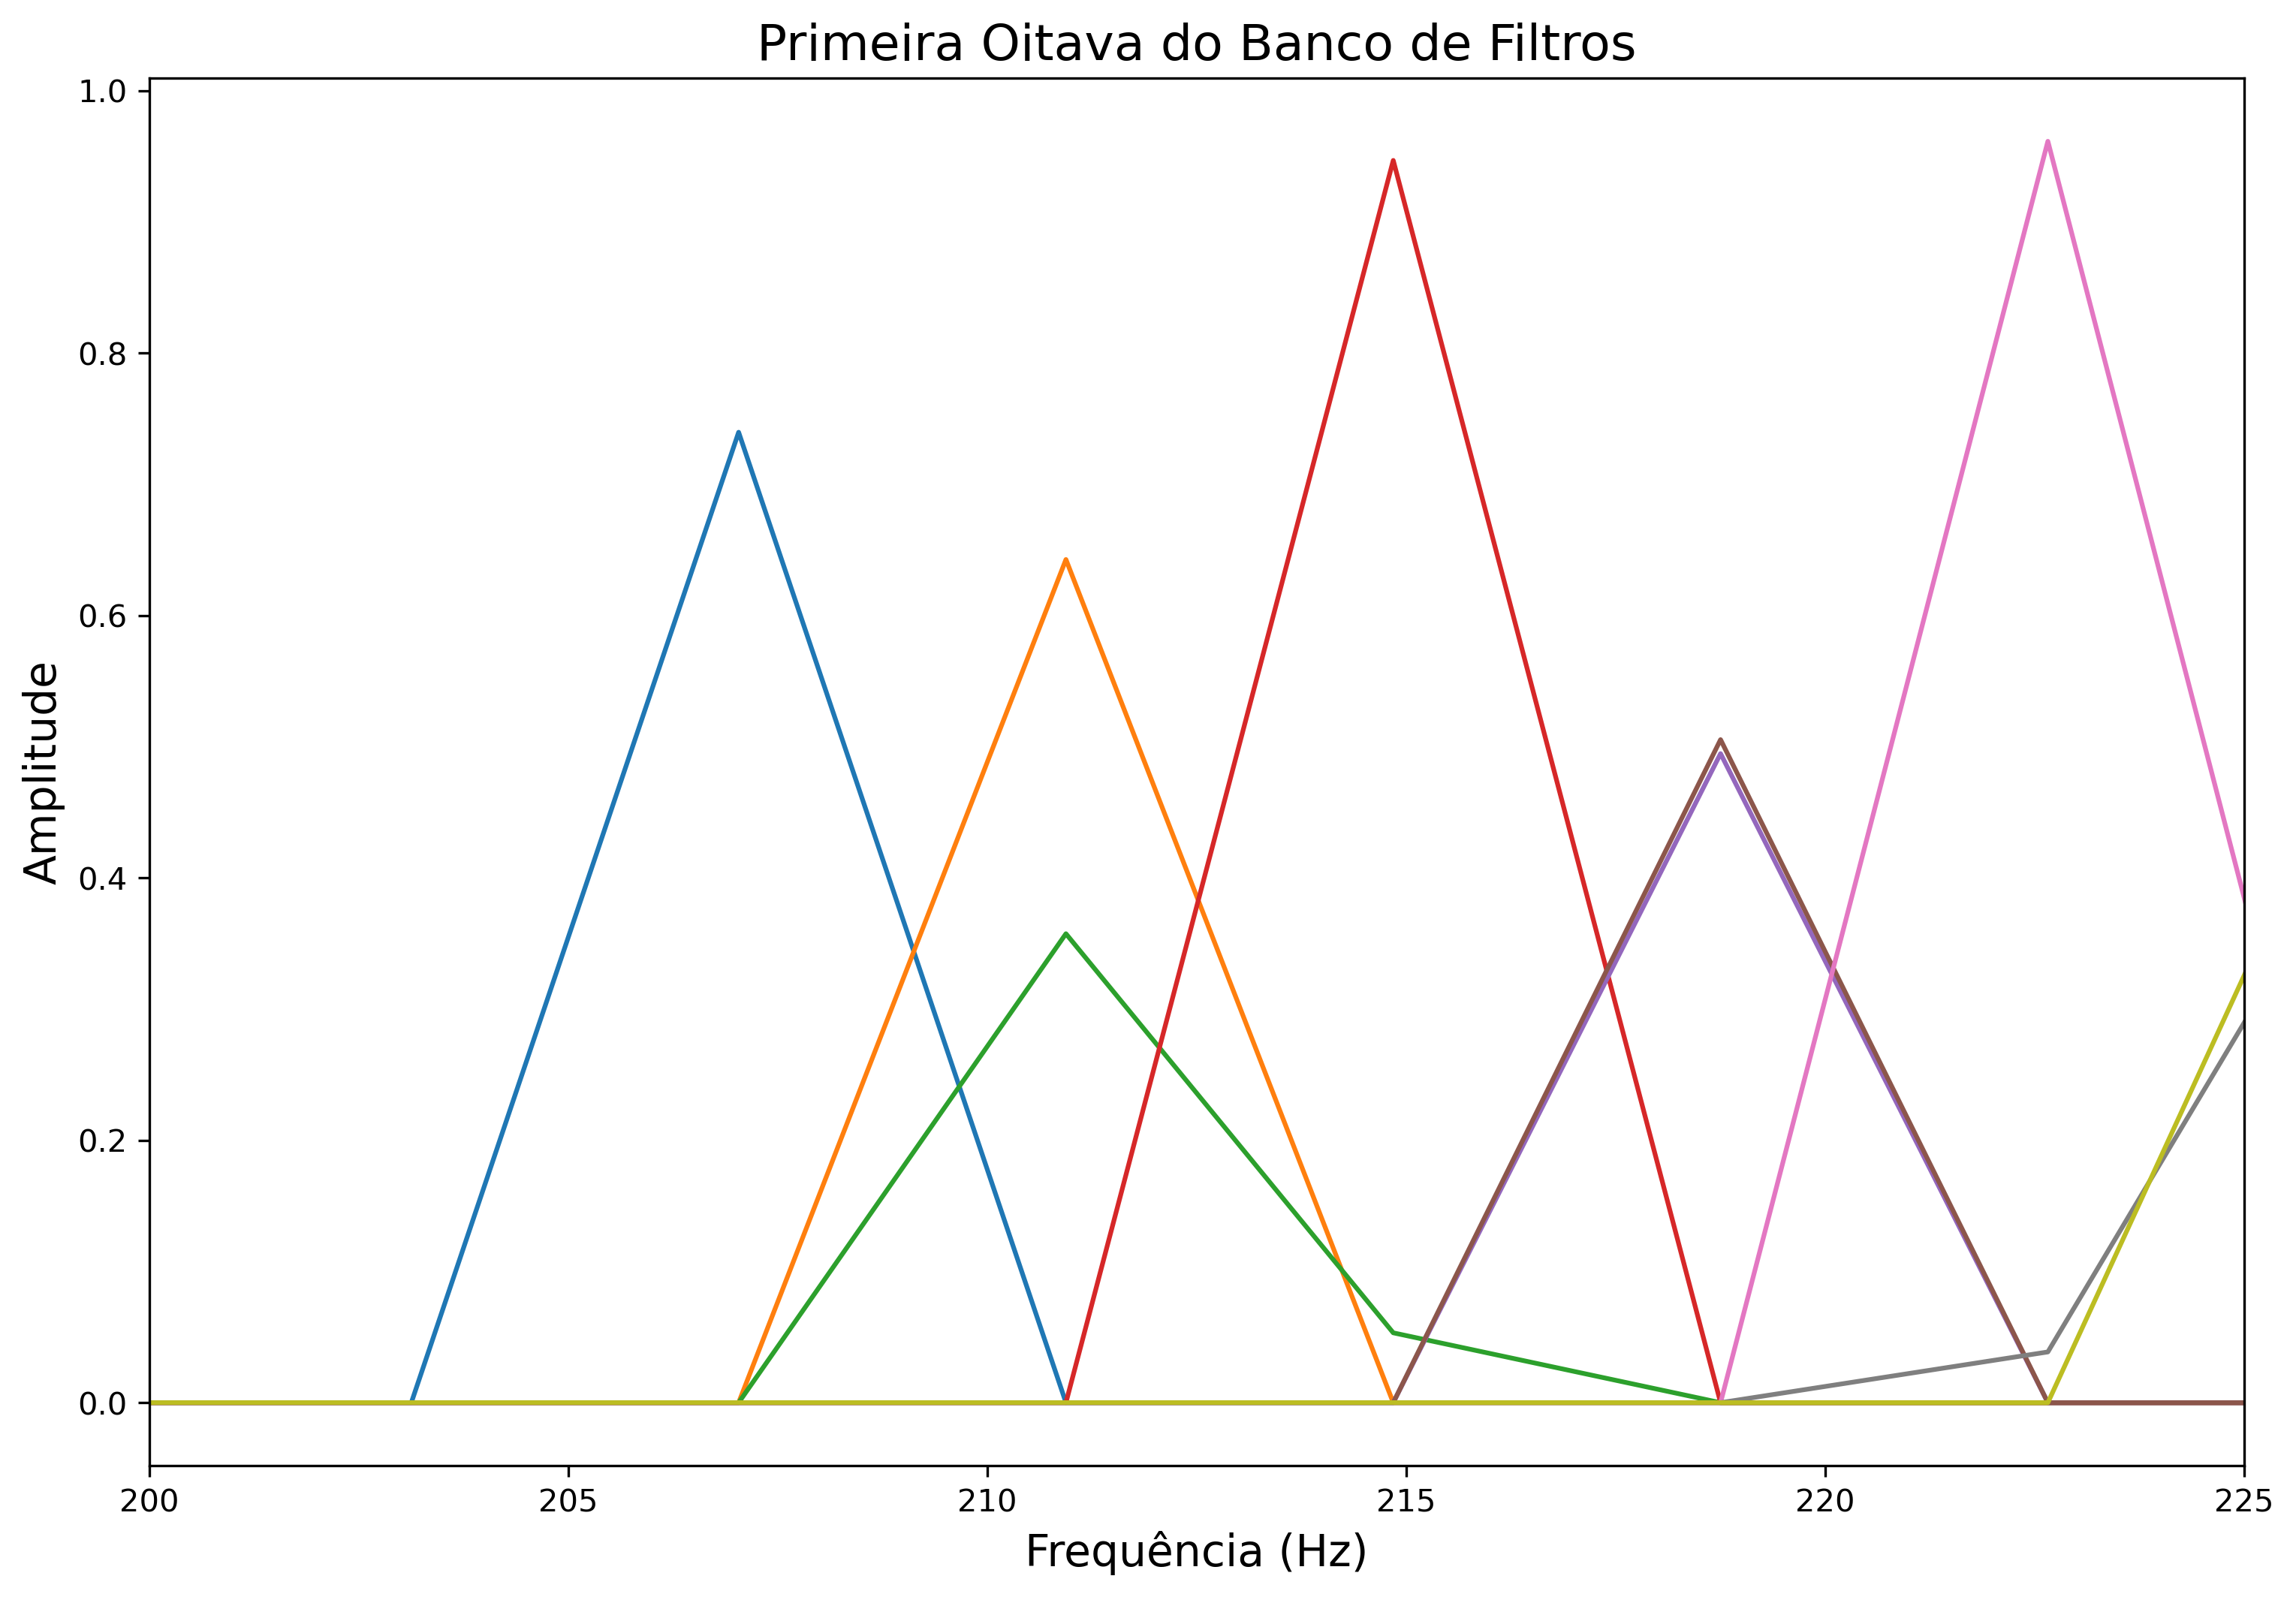

self.tr_source_fps:['/mnt/dataset/public/Fingerprinting/neural-audio-fp-dataset/music/train-10k-30s/fma_small_8k_plus_medium_2k/000/000625.wav']
fns_list=['/mnt/dataset/public/Fingerprinting/neural-audio-fp-dataset/music/train-10k-30s/fma_small_8k_plus_medium_2k/000/000625.wav']
fns_event_seg_list:[['/mnt/dataset/public/Fingerprinting/neural-audio-fp-dataset/music/train-10k-30s/fma_small_8k_plus_medium_2k/000/000625.wav', 20, -4000, 4000.0]]
self.n_samples: 1
fns_list=['/mnt/dataset/public/Fingerprinting/neural-audio-fp-dataset/aug/bg/tr/audioset_subway_metro_underground_not_music/Y-ADTZNx531s_340.wav', '/mnt/dataset/public/Fingerprinting/neural-audio-fp-dataset/aug/bg/tr/audioset_subway_metro_underground_not_music/Y-D1uGn8bvIA_40.wav', '/mnt/dataset/public/Fingerprinting/neural-audio-fp-dataset/aug/bg/tr/audioset_subway_metro_underground_not_music/Y-DZN4RxMD3s_140.wav', '/mnt/dataset/public/Fingerprinting/neural-audio-fp-dataset/aug/bg/tr/audioset_subway_metro_underground_not_music/Y-

In [438]:
# Dataloader
dataset = Dataset(cfg)

# Build models.
m_pre, m_specaug, m_fp = build_fp(cfg)

# Learning schedule
total_nsteps = cfg['TRAIN']['MAX_EPOCH'] * len(dataset.get_train_ds())
if cfg['TRAIN']['LR_SCHEDULE'].upper() == 'COS':
    lr_schedule = tf.keras.experimental.CosineDecay(
        initial_learning_rate=float(cfg['TRAIN']['LR']),
        decay_steps=total_nsteps,
        alpha=1e-06)
elif cfg['TRAIN']['LR_SCHEDULE'].upper() == 'COS-RESTART':
    lr_schedule = tf.keras.experimental.CosineDecayRestarts(
        initial_learning_rate=float(cfg['TRAIN']['LR']),
        first_decay_steps=int(total_nsteps * 0.1),
        num_periods=0.5,
        alpha=2e-06)
else:
    lr_schedule = float(cfg['TRAIN']['LR'])

# Optimizer
if cfg['TRAIN']['OPTIMIZER'].upper() == 'LAMB':
    opt = LAMB(learning_rate=lr_schedule)
elif cfg['TRAIN']['OPTIMIZER'].upper() == 'ADAM':
    opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
else:
    raise NotImplementedError(cfg['TRAIN']['OPTIMIZER'])

# Experiment helper: see utils.experiment_helper.py for details.
helper = ExperimentHelper(
    checkpoint_name=checkpoint_name,
    optimizer=opt,
    model_to_checkpoint=m_fp,
    cfg=cfg)

# Loss objects
if cfg['LOSS']['LOSS_MODE'].upper() == 'NTXENT': # Default
    loss_obj_train = NTxentLoss(
        n_org=cfg['BSZ']['TR_N_ANCHOR'],
        n_rep=cfg['BSZ']['TR_BATCH_SZ'] - cfg['BSZ']['TR_N_ANCHOR'],
        tau=cfg['LOSS']['TAU'])
    loss_obj_val = NTxentLoss(
        n_org=cfg['BSZ']['VAL_N_ANCHOR'],
        n_rep=cfg['BSZ']['VAL_BATCH_SZ'] - cfg['BSZ']['VAL_N_ANCHOR'],
        tau=cfg['LOSS']['TAU'])
elif cfg['LOSS']['LOSS_MODE'].upper() == 'ONLINE-TRIPLET': # Now-playing
    loss_obj_train = OnlineTripletLoss(
        bsz=cfg['BSZ']['TR_BATCH_SZ'],
        n_anchor=cfg['BSZ']['TR_N_ANCHOR'],
        mode = 'semi-hard',
        margin=cfg['LOSS']['MARGIN'])
    loss_obj_val = OnlineTripletLoss(
        bsz=cfg['BSZ']['VAL_BATCH_SZ'],
        n_anchor=cfg['BSZ']['VAL_N_ANCHOR'],
        mode = 'all', # use 'all' mode for validation
        margin=0.)
else:
    raise NotImplementedError(cfg['LOSS']['LOSS_MODE'])

Múscia da base de dados FMA

In [103]:
# Data location
source_root_dir = cfg['DIR']['SOURCE_ROOT_DIR']

# Data selection
datasel_train = cfg['DATA_SEL']['TRAIN']

# BSZ
tr_batch_sz = cfg['BSZ']['TR_BATCH_SZ']
tr_n_anchor = cfg['BSZ']['TR_N_ANCHOR']

# Model parameters
dur = cfg['MODEL']['DUR']
hop = cfg['MODEL']['HOP']
fs = cfg['MODEL']['FS']

# Time-domain augmentation parameter
tr_snr = cfg['TD_AUG']['TR_SNR']
ts_snr = cfg['TD_AUG']['TS_SNR']
val_snr = cfg['TD_AUG']['VAL_SNR']
tr_use_bg_aug = cfg['TD_AUG']['TR_BG_AUG']
ts_use_bg_aug = cfg['TD_AUG']['TS_BG_AUG']
val_use_bg_aug = cfg['TD_AUG']['VAL_BG_AUG']
tr_use_ir_aug = cfg['TD_AUG']['TR_IR_AUG']
ts_use_ir_aug = cfg['TD_AUG']['TS_IR_AUG']
val_use_ir_aug = cfg['TD_AUG']['VAL_IR_AUG']
tr_use_speech_aug = cfg['TD_AUG']['TR_SPEECH_AUG']
ts_use_speech_aug = cfg['TD_AUG']['TS_SPEECH_AUG']
val_use_speech_aug = cfg['TD_AUG']['VAL_SPEECH_AUG']

# Pre-load file paths for augmentation
tr_bg_fps = ts_bg_fps = val_bg_fps = None
tr_ir_fps = ts_ir_fps = val_ir_fps = None
tr_speech_fps = ts_speech_fps = val_speech_fps = None
#__set_augmentation_fps()

# Source (music) file paths
tr_source_fps = val_source_fps = audio = None #'/mnt/dataset/public/Fingerprinting/neural-audio-fp-dataset/music/train-10k-30s/fma_small_8k_plus_medium_2k/000/000002.wav'
ts_dummy_db_source_fps = None
ts_query_icassp_fps = ts_db_icassp_fps = None
ts_query_db_unseen_fps = None

In [104]:
print(tr_source_fps)

None


In [20]:
"""
tr_source_fps = sorted(
    glob.glob('/mnt/dataset/public/Fingerprinting/neural-audio-fp-dataset/music/train-10k-30s/fma_small_8k_plus_medium_2k/000/000002.wav',
                recursive=True))

ds = genUnbalSequence(
    fns_event_list=tr_source_fps,
    bsz=tr_batch_sz,
    n_anchor=tr_n_anchor, #ex) bsz=40, n_anchor=8: 4 positive samples per anchor
    duration=dur,  # duration in seconds
    hop=hop,
    fs=fs,
    shuffle=True,
    random_offset_anchor=True,
    bg_mix_parameter=[tr_use_bg_aug, tr_bg_fps, tr_snr],
    ir_mix_parameter=[tr_use_ir_aug, tr_ir_fps],
    speech_mix_parameter=[tr_use_speech_aug, tr_speech_fps,
                            tr_snr],
    reduce_items_p=0)
"""

"\ntr_source_fps = sorted(\n    glob.glob('/mnt/dataset/public/Fingerprinting/neural-audio-fp-dataset/music/train-10k-30s/fma_small_8k_plus_medium_2k/000/000002.wav',\n                recursive=True))\n\nds = genUnbalSequence(\n    fns_event_list=tr_source_fps,\n    bsz=tr_batch_sz,\n    n_anchor=tr_n_anchor, #ex) bsz=40, n_anchor=8: 4 positive samples per anchor\n    duration=dur,  # duration in seconds\n    hop=hop,\n    fs=fs,\n    shuffle=True,\n    random_offset_anchor=True,\n    bg_mix_parameter=[tr_use_bg_aug, tr_bg_fps, tr_snr],\n    ir_mix_parameter=[tr_use_ir_aug, tr_ir_fps],\n    speech_mix_parameter=[tr_use_speech_aug, tr_speech_fps,\n                            tr_snr],\n    reduce_items_p=0)\n"

In [40]:
train_ds = dataset.get_train_ds(cfg['DATA_SEL']['REDUCE_ITEMS_P'])

self.tr_source_fps:['/mnt/dataset/public/Fingerprinting/neural-audio-fp-dataset/music/train-10k-30s/fma_small_8k_plus_medium_2k/000/000625.wav']
fns_list=['/mnt/dataset/public/Fingerprinting/neural-audio-fp-dataset/music/train-10k-30s/fma_small_8k_plus_medium_2k/000/000625.wav']
fns_event_seg_list:[['/mnt/dataset/public/Fingerprinting/neural-audio-fp-dataset/music/train-10k-30s/fma_small_8k_plus_medium_2k/000/000625.wav', 20, -4000, 4000.0]]
self.n_samples: 1
fns_list=['/mnt/dataset/public/Fingerprinting/neural-audio-fp-dataset/aug/bg/tr/audioset_subway_metro_underground_not_music/Y-ADTZNx531s_340.wav', '/mnt/dataset/public/Fingerprinting/neural-audio-fp-dataset/aug/bg/tr/audioset_subway_metro_underground_not_music/Y-D1uGn8bvIA_40.wav', '/mnt/dataset/public/Fingerprinting/neural-audio-fp-dataset/aug/bg/tr/audioset_subway_metro_underground_not_music/Y-DZN4RxMD3s_140.wav', '/mnt/dataset/public/Fingerprinting/neural-audio-fp-dataset/aug/bg/tr/audioset_subway_metro_underground_not_music/Y-

In [41]:
print(train_ds.fns_event_seg_list)

[['/mnt/dataset/public/Fingerprinting/neural-audio-fp-dataset/music/train-10k-30s/fma_small_8k_plus_medium_2k/000/000625.wav', 20, -4000, 4000.0]]


In [42]:
enq = tf.keras.utils.OrderedEnqueuer(
    train_ds, use_multiprocessing=True, shuffle=train_ds.shuffle)
enq.start(workers=cfg['DEVICE']['CPU_N_WORKERS'],
            max_queue_size=cfg['DEVICE']['CPU_MAX_QUEUE'])

In [43]:
train_ds.n_samples

1

In [44]:
X = next(enq.get()) # X: Tuple(Xa, Xp)

In [45]:
tf.print(f"X:{X}")

X:(array([[[ 0.23712158,  0.18383789,  0.17102051, ...,  0.06304932,
         -0.06399536, -0.08309937]]], dtype=float32), array([[[-0.4444952 , -0.30892995, -0.00985348, ...,  0.2856081 ,
          0.08885875, -0.29129323]]], dtype=float32))


In [46]:
#i = 0
#while i < len(enq.sequence):
#X = next(enq.get()) # X: Tuple(Xa, Xp)
#tf.print(f"X:{X}")

In [47]:
tf.print(f"X_shape{X[0]}")

X_shape[[[ 0.23712158  0.18383789  0.17102051 ...  0.06304932 -0.06399536
   -0.08309937]]]


In [48]:
spectogram_values = m_pre(X[0])
print(spectogram_values.shape)

x do log=Tensor("strided_slice:0", shape=(1, 32, 256), dtype=float32)
(1, 256, 32, 1)


In [49]:
"""spectrogram_to_plot = np.squeeze(spectogram_values)

# Verifique a forma após a transformação
#print(spectrogram_to_plot.shape)
vmin = np.min(spectrogram_to_plot)
vmax = np.max(spectrogram_to_plot)
print(f"Valor mínimo: {vmin}, Valor máximo: {vmax}")

# Plote o espectrograma
plt.figure(figsize=(20, 10), dpi=200)
plt.imshow(spectrogram_to_plot, aspect='auto', origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar(label='Intensidade')
plt.title('Espectrograma')
plt.ylabel('Frequência')
plt.xlabel('Tempo')
plt.show()"""

'spectrogram_to_plot = np.squeeze(spectogram_values)\n\n# Verifique a forma após a transformação\n#print(spectrogram_to_plot.shape)\nvmin = np.min(spectrogram_to_plot)\nvmax = np.max(spectrogram_to_plot)\nprint(f"Valor mínimo: {vmin}, Valor máximo: {vmax}")\n\n# Plote o espectrograma\nplt.figure(figsize=(20, 10), dpi=200)\nplt.imshow(spectrogram_to_plot, aspect=\'auto\', origin=\'lower\', cmap=\'viridis\', vmin=vmin, vmax=vmax)\nplt.colorbar(label=\'Intensidade\')\nplt.title(\'Espectrograma\')\nplt.ylabel(\'Frequência\')\nplt.xlabel(\'Tempo\')\nplt.show()'

In [50]:
spectrogram_to_plot = np.squeeze(spectogram_values)
vmin = np.min(spectrogram_to_plot)
vmax = np.max(spectrogram_to_plot)
print(f"Valor mínimo: {vmin}, Valor máximo: {vmax}")

# Plote o espectrograma com tamanho e resolução aumentados
plt.figure(figsize=(20, 10), dpi=200)  # Tamanho da figura em polegadas e resolução em DPI
img = plt.imshow(spectrogram_to_plot, aspect='auto', origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
#plt.colorbar(img, label='Intensidade')
plt.colorbar(img)
plt.title('Espectrograma', fontsize=20)  # Tamanho da fonte ajustado para o título
#plt.ylabel('Frequência', fontsize=16)  # Tamanho da fonte ajustado para o rótulo do eixo Y
#plt.xlabel('Tempo', fontsize=16)  # Tamanho da fonte ajustado para o rótulo do eixo X

# Ajuste os tamanhos dos ticks (marcadores nos eixos)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Exibir o gráfico
plt.show()

Valor mínimo: -49.29450225830078, Valor máximo: 0.0


<IPython.core.display.Javascript object>

Sinal de teste para implementação de N e Nfft diferentes

In [51]:
n_win = cfg['MODEL']['N_WIN']
fs = cfg['MODEL']['FS']

n1 = np.arange(0, (n_win-1)/2)  # 3*M amostras
n2 = np.arange(0, n_win-1)      # 6*M amostras

In [52]:
x1 = np.sin(2 * np.pi * 3520 / fs * n1)  # 3*M Deixa um "rasto" de mais 3 tramas (6 tramas).
x2 = np.zeros(n_win-1)                       # 6*M A 7ª trama só tem zeros
x3 = np.sin(2 * np.pi * 880 / fs * n2)   # 6*M A 13ª trama só tem tom a 880 Hz
x4 = np.sin(2 * np.pi * 440 / fs * n2)   # 6*M A 19ª trama só tem tom a 440 Hz
x5 = 2 * np.random.rand(n_win-1) - 1         # Ruído uniforme entre -1 e 1; 6*M
x6 = np.sin(2 * np.pi * 2200 / fs * np.arange(0, 1028))  # 3*M ruído com distribuição uniforme entre -1 e 1; 6*M. A 25ª trama só tem ruido
x7=1

x = np.concatenate([x1, [0], x2, [0], x3, [0], x4, [0], x5, [0], x6, [0]]) #adicionei este 0 para dar 8000 amostras

In [53]:
len(x) #tamanho do sinal 7999

8000

In [54]:
plt.figure()
plt.plot(x)
plt.xlabel('Amostras')
plt.ylabel('Amplitude')
plt.title('Sinal x')
plt.show()

<IPython.core.display.Javascript object>

In [55]:
stft_hop = 258
Npad_l = 3*stft_hop
Npad_r = 3*stft_hop-1

In [56]:
xbuf = np.concatenate([np.zeros(Npad_l), x, np.zeros(Npad_r)])

In [57]:
plt.figure()
plt.plot(xbuf)
plt.xlabel('Amostras')
plt.ylabel('Amplitude')
plt.title('Sinal com padding')
plt.show()

<IPython.core.display.Javascript object>

In [58]:
def buffer(arr, n, p=0, opt='none'):
    """
    Segmenta o vetor `arr` em colunas de comprimento `n` com sobreposição de `p` elementos.
    
    Parâmetros:
    arr: vetor de entrada (1D numpy array)
    n: tamanho de cada janela (int)
    p: sobreposição entre janelas consecutivas (int, opcional, padrão 0)
    opt: 'nodelay' para não atrasar a janela, 'none' para comportamento padrão (string, opcional)
    
    Retorna:
    2D numpy array com as janelas segmentadas como colunas.
    """
    arr = np.asarray(arr)
    step = n - p
    if step <= 0:
        raise ValueError("A sobreposição p deve ser menor que o tamanho da janela n.")
    
    if opt == 'nodelay':
        num_windows = int(np.ceil(len(arr) / float(step)))
    else:
        num_windows = int(np.floor((len(arr) - p) / float(step))) + 1
    
    shape = (num_windows, n)
    buffer_matrix = np.zeros(shape)

    for i in range(num_windows):
        start = i * step
        end = start + n
        buffer_matrix[i, :len(arr[start:end])] = arr[start:end]

    return buffer_matrix

In [59]:
"""def buffer(sig, frame_len, overlap):
    step = frame_len - overlap
    shape = (sig.size - overlap, frame_len)
    strides = (sig.strides[0], sig.strides[0])
    return np.lib.stride_tricks.as_strided(sig, shape=shape, strides=strides)[::step]"""

'def buffer(sig, frame_len, overlap):\n    step = frame_len - overlap\n    shape = (sig.size - overlap, frame_len)\n    strides = (sig.strides[0], sig.strides[0])\n    return np.lib.stride_tricks.as_strided(sig, shape=shape, strides=strides)[::step]'

In [60]:
# buffer
xf = buffer(xbuf, n_win, n_win-stft_hop)

In [70]:
plt.figure()
plt.plot(xf[6, :])
plt.xlabel('Amostras')
plt.ylabel('Amplitude')
plt.title('Sinal da 7ª Trama')
plt.show()

/tmp/ipykernel_1356530/2705843332.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [71]:
xf.shape, xf.shape[1]

((33, 1549), 1549)

In [72]:
m_pre, _, _ = build_fp(cfg)

In [102]:
x_tensor = tf.convert_to_tensor(x, dtype=tf.float32) # <tf.Tensor: shape=(9546,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>

In [103]:
x_tensor

<tf.Tensor: shape=(8000,), dtype=float32, numpy=
array([ 0.        ,  0.36812454, -0.6845471 , ...,  0.18738131,
        0.77051324,  1.        ], dtype=float32)>

In [104]:
x_tensor = tf.reshape(x_tensor, (1, 1, -1)) # <tf.Tensor: shape=(1, 1, 9546), dtype=float32, numpy=array([[[0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

In [105]:
x_tensor

<tf.Tensor: shape=(1, 1, 8000), dtype=float32, numpy=
array([[[ 0.        ,  0.36812454, -0.6845471 , ...,  0.18738131,
          0.77051324,  1.        ]]], dtype=float32)>

In [106]:
Y=m_pre(x_tensor)

In [108]:
Y

<tf.Tensor: shape=(1, 256, 32, 1), dtype=float32, numpy=
array([[[[-66.5739  ],
         [-66.69918 ],
         [-66.8697  ],
         ...,
         [-65.93054 ],
         [-62.1033  ],
         [-58.547245]],

        [[-66.50864 ],
         [-66.71371 ],
         [-66.96924 ],
         ...,
         [-65.38641 ],
         [-60.5127  ],
         [-61.128826]],

        [[-66.678955],
         [-66.80841 ],
         [-66.96616 ],
         ...,
         [-65.85468 ],
         [-62.125343],
         [-62.109634]],

        ...,

        [[-34.999256],
         [-37.24897 ],
         [-44.930084],
         ...,
         [-59.344307],
         [-52.330997],
         [-50.099392]],

        [[-35.363922],
         [-37.62027 ],
         [-45.296234],
         ...,
         [-59.305717],
         [-52.281403],
         [-50.048157]],

        [[-35.57972 ],
         [-37.831226],
         [-45.517586],
         ...,
         [-59.266876],
         [-52.245766],
         [-50.012264]]]], dtyp

In [79]:
Y_reshaped = tf.squeeze(Y, axis=(0, 3))  # Remove-se os eixos do Batch e Canal. (B,F,T,C) -> (F,T)
plt.figure()
plt.imshow(Y_reshaped, aspect='auto', origin='lower')
plt.colorbar()
#plt.title('CQT Spectrogram')
plt.xlabel('Tramas de 1 a 32')
plt.ylabel('Canais: de 1 a 256')

Text(0, 0.5, 'Canais: de 1 a 256')

Sinal de teste antes de 28 de maio, para implementação antiga de CQT

In [80]:
import numpy as np
import matplotlib.pyplot as plt

In [81]:
# Parâmetros
fs = 8000
Nx = fs  # 1 segundo de sinal
N = 2048  # comprimento da janela
M = 192  # hop-size

# Sinal x
x = np.zeros(Nx)
x[0:2048] = np.sin(2 * np.pi * 3520 / fs * np.arange(2048))
x[2049:2049 + 11 * 192] = 0
x[22 * M:8000] = np.sin(2 * np.pi * 880 / fs * np.arange(3776))

In [82]:
m_pre, _, _ = build_fp(cfg)

In [83]:
x_tensor = tf.convert_to_tensor(x, dtype=tf.float32) #<tf.Tensor: shape=(120, 1, 8000), dtype=float32, numpy=...>
                        #<tf.Tensor: shape=(B, 1, 8000), dtype=float32, numpy=...>

In [84]:
x_tensor

<tf.Tensor: shape=(8000,), dtype=float32, numpy=
array([ 0.        ,  0.36812454, -0.6845471 , ...,  0.18738131,
        0.77051324,  1.        ], dtype=float32)>

In [85]:
x_tensor = tf.reshape(x_tensor, (1, 1, -1))

In [86]:
x_tensor

<tf.Tensor: shape=(1, 1, 8000), dtype=float32, numpy=
array([[[ 0.        ,  0.36812454, -0.6845471 , ...,  0.18738131,
          0.77051324,  1.        ]]], dtype=float32)>

In [87]:
Y=m_pre(x_tensor)

In [88]:
Y

<tf.Tensor: shape=(1, 256, 32, 1), dtype=float32, numpy=
array([[[[-66.5739  ],
         [-66.69918 ],
         [-66.8697  ],
         ...,
         [-65.93054 ],
         [-62.1033  ],
         [-58.547245]],

        [[-66.50864 ],
         [-66.71371 ],
         [-66.96924 ],
         ...,
         [-65.38641 ],
         [-60.5127  ],
         [-61.128826]],

        [[-66.678955],
         [-66.80841 ],
         [-66.96616 ],
         ...,
         [-65.85468 ],
         [-62.125343],
         [-62.109634]],

        ...,

        [[-34.999256],
         [-37.24897 ],
         [-44.930084],
         ...,
         [-59.344307],
         [-52.330997],
         [-50.099392]],

        [[-35.363922],
         [-37.62027 ],
         [-45.296234],
         ...,
         [-59.305717],
         [-52.281403],
         [-50.048157]],

        [[-35.57972 ],
         [-37.831226],
         [-45.517586],
         ...,
         [-59.266876],
         [-52.245766],
         [-50.012264]]]], dtyp

In [89]:
#<tf.Tensor: shape=(1, 256, 32, 1), dtype=float32, numpy=...>
Y_reshaped = tf.squeeze(Y, axis=(0, 3))  # Remove-se os eixos do Batch e Canal. (B,F,T,C) -> (F,T)
plt.figure(1)
plt.imshow(Y_reshaped, aspect='auto', origin='lower')
plt.colorbar()
#plt.title('CQT Spectrogram')
plt.xlabel('Tramas de 1 a 32')
plt.ylabel('Canais: de 1 a 256')

Text(0, 0.5, 'Canais: de 1 a 256')

In [90]:
Nfpo=60

f256 = 440*2.**(38/12) # Si7 = 3951.066410048992 Hz;
f0=f256/2**(256/Nfpo) # fmin, 205.2672581380976 Hz
fmax = f0*2**(257/Nfpo) # fmax, 3996.975590329487 Hz

i=np.arange(1,256+1, dtype=np.int32)
#k=np.arange(n_fft//2+1)
#f=k*sample_rate/n_fft

fcf = f0 * 2.**(i/Nfpo) #3905.68454168

#fi = np.concatenate(([f0], fcf, [fmax])) #fi =[f0, fcf, fmax] 

In [ ]:
fcf[257] 

In [91]:
# Dados
tramas = np.arange(0, 32)
diff_fc = np.diff(np.concatenate((fcf, [4000])))
#f_centrais = fcf - np.diff(np.concatenate(([fi[0]], fi, [4000]))) // 2
fc2 = fcf - diff_fc / 2

In [92]:
fig = plt.figure(2)
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(tramas, fc2)
surf = ax.plot_surface(X, Y, Y_reshaped, cmap='jet', edgecolor='none')
fig.colorbar(surf, label='dB')

# Configurações de visualização
ax.view_init(90, -90)
ax.set_xlabel('Tramas de 0 a 31')
ax.set_ylabel('fCentrais em Hertz')
ax.set_zlabel('dB')

plt.show()

/tmp/ipykernel_1356530/1507560125.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [93]:
plt.figure(3)
plt.plot(np.arange(Nx), x)
plt.title('Signal')
plt.xlabel('Amostras')
plt.ylabel('Amplitude')
plt.show()

/tmp/ipykernel_1356530/870855293.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


Dados

In [94]:
train_ds = dataset.get_train_ds(0)
enq = tf.keras.utils.OrderedEnqueuer(
        train_ds, use_multiprocessing=True, shuffle=train_ds.shuffle)
enq.start(workers=cfg['DEVICE']['CPU_N_WORKERS'],
        max_queue_size=cfg['DEVICE']['CPU_MAX_QUEUE'])

In [95]:
X = next(enq.get())

In [96]:
n_anchors = len(X[0])
X = tf.concat(X, axis=0)

In [97]:
X

<tf.Tensor: shape=(120, 1, 8000), dtype=float32, numpy=
array([[[-0.17895508, -0.17944336, -0.20367432, ...,  0.6025696 ,
          0.4859619 ,  0.5409851 ]],

       [[ 0.19100952,  0.2534485 ,  0.33096313, ..., -0.28433228,
         -0.27911377, -0.27716064]],

       [[-0.04650879, -0.16534424,  0.17959595, ...,  0.14596558,
          0.2836914 ,  0.2783203 ]],

       ...,

       [[ 0.21242866,  0.2593347 , -0.09338675, ..., -0.0114378 ,
          0.29726022,  0.02588185]],

       [[ 0.36831185, -0.06240391, -0.3265456 , ..., -0.05286588,
          0.6224227 , -0.7057687 ]],

       [[ 0.1558583 ,  0.10181317, -0.09779693, ...,  0.13006592,
          0.5936842 ,  0.15725462]]], dtype=float32)>

teste - a ver se funciona

In [98]:
m_pre(X)

<tf.Tensor: shape=(120, 256, 32, 1), dtype=float32, numpy=
array([[[[-30.683542],
         [-29.843153],
         [-31.647482],
         ...,
         [-16.13078 ],
         [-17.562325],
         [-21.5499  ]],

        [[-35.238987],
         [-35.120388],
         [-40.387917],
         ...,
         [-19.55257 ],
         [-18.824694],
         [-22.171515]],

        [[-37.617485],
         [-37.509045],
         [-42.526497],
         ...,
         [-21.918512],
         [-21.085455],
         [-24.326296]],

        ...,

        [[-40.900383],
         [-39.028645],
         [-39.632336],
         ...,
         [-47.130165],
         [-44.406075],
         [-44.467026]],

        [[-51.682076],
         [-50.835693],
         [-51.677452],
         ...,
         [-55.91187 ],
         [-51.87176 ],
         [-50.627575]],

        [[-55.673523],
         [-57.158985],
         [-59.23559 ],
         ...,
         [-59.514565],
         [-56.55307 ],
         [-54.744682]]],


 

In [99]:
#Passo seguinte, alterar o data augmentation antes de treinar.
feat = m_specaug(m_pre(X)) 

2024-06-09 18:14:18.607103: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: sequential_411/spec_n_cutout_6/StatefulPartitionedCall/cond_1/branch_executed/_30


In [100]:
import os
import csv

folder_path = './DadosDebugMostrarProfessor'
file_name = 'X_antes_concat_trainStep.csv'
os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)


with open(file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    for array in X:
        writer.writerow(array)

print('Feito')

Feito


DataAug

In [ ]:
import sys
sys.path.append('/home/rodrigo/Documents/neural-audio-fp/model_RA/fp/specaug_chain/')


In [ ]:
from model_RA.fp.specaug_chain.specaug_chain_RA import get_specaug_chain_layer

In [ ]:
get_specaug_chain_layer()

In [ ]:
from model.fp.specaug_chain.specaug_chain import get_specaug_chain_layer
from model.fp.specaug_chain.specaug_chain import display_spec
from model.fp.specaug_chain.specaug_chain import plot_to_image
from model.fp.specaug_chain.specaug_chain import test_chain

In [ ]:
get_specaug_chain_layer(cfg, trainable=False)

In [ ]:
test_chain()